In [1]:
import numpy as np
import pandas as pd

In [2]:
pat_demo = pd.read_csv('data/Patient_Demo.csv')

In [3]:
pat_visit = pd.read_csv('data/Patient_Hospital_Visit.csv')

In [4]:
pat_demo.head()

,institution_id,patient_id,dob,sex,state
0,9db63f62-5c58-4303-919e-e23681909271,273KC6WWA,1993-03-06,male,Ogun
1,6762b0cd-12c6-4026-8886-ce15a48a6398,28D62KK5S,1959-04-20,male,kano
2,0fa2e546-c292-4060-a05e-beb53fc31e72,2CEW8BKP6,1935-10-09,female,delta
3,4bb14745-4254-4247-9b84-bd4fc63583b0,2DKKD2X8R,1950-12-03,male,Cross River State
4,3b883d89-83bd-41a1-9eb1-ee76eb22d897,2GBEK724E,1981-07-13,male,Akwa Ibom


In [5]:
demo_visit_df = pat_visit.merge(pat_demo, on=['patient_id', 'institution_id'], how='left')

In [6]:
demo_visit_df.isnull().sum()/demo_visit_df.shape[0]

visit_id          0.000000
patient_id        0.000000
institution_id    0.000000
admitted_at       0.959907
discharged_at     0.959684
inserted_at       0.000000
updated_at        0.000000
visit_type        0.000000
type              0.000000
dob               0.001471
sex               0.001661
state             0.256507
dtype: float64

In [7]:
demo_visit_df = demo_visit_df.dropna(subset=['state', 'dob', 'sex'])

In [8]:
demo_visit_df.shape

(333534, 12)

In [9]:
# import datetime

#df['age'] =

demo_visit_df['dob'] = pd.to_datetime(demo_visit_df['dob'])
demo_visit_df['inserted_at'] = pd.to_datetime(demo_visit_df['inserted_at'])

In [10]:
demo_visit_df['age'] = np.floor((demo_visit_df['inserted_at'] - demo_visit_df['dob']).dt.days/365).astype(int)

In [11]:
demo_visit_df['age_bin'] = pd.cut(demo_visit_df['age'], 4, labels=['Children/Teens', 'Adult', 'older adult', 'senior citizen'])

In [12]:
demo_visit_df['visit_month'] = demo_visit_df['inserted_at'].dt.month
demo_visit_df['visit_day'] = demo_visit_df['inserted_at'].dt.day

In [13]:
## The number of times a patient has visited a hospital, clinic, lab within a month

no_of_visit = demo_visit_df.groupby(['patient_id', 'inserted_at', 'type'])['type'].count().unstack().fillna(0).rename(columns={'clinic':'clinic_visit','hospital':'hospital_visit', 'laboratory':'lab_visit'})

In [14]:
no_of_visit = no_of_visit.reset_index()

In [15]:
demo_visit_df = demo_visit_df.merge(no_of_visit, on=['patient_id', 'inserted_at'], how='left')

In [16]:
institution_visit = demo_visit_df.groupby(['inserted_at', 'institution_id'])['visit_id'].count().reset_index().rename(columns={'visit_id':'institution_visit_day'})

In [17]:
# Total number of patients admitted to the hospital in a day.
demo_visit_df = demo_visit_df.merge(institution_visit, on=['inserted_at', 'institution_id'], how='left')

In [18]:
demo_visit_df.shape

(333534, 20)

In [19]:
# demo_visit_df[demo_visit_df['state'].str.startswith('a')]['state'].unique()

In [20]:
train_df = demo_visit_df[demo_visit_df['inserted_at'].astype('str') <= '2021-06-31']
test_df = demo_visit_df[demo_visit_df['inserted_at'].astype('str') > '2021-06-31']

In [21]:
new_data = demo_visit_df.drop(['admitted_at', 'discharged_at','dob', 'visit_id', 'patient_id', 'inserted_at', 'institution_id','age', 'updated_at'], axis=1)

train_df = train_df.drop(['admitted_at', 'discharged_at','dob', 'visit_id', 'patient_id', 'inserted_at', 'institution_id','age', 'updated_at'], axis=1)

test_df = test_df.drop(['admitted_at', 'discharged_at','dob', 'visit_id', 'patient_id', 'inserted_at', 'institution_id','age', 'updated_at'], axis=1)


In [22]:
cat_col = ['visit_type', 'type', 'state', 'sex']
num_col = ['visit_month', 'visit_day', 'clinic_visit', 'hospital_visit', 'lab_visit', 'institution_visit_day']

new_data = new_data.drop_duplicates()
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in cat_col:
    new_data[col] = label_encoder.fit_transform(new_data[col])
    train_df[col] = label_encoder.fit_transform(train_df[col])
    test_df[col] = label_encoder.fit_transform(test_df[col])

In [24]:
from sklearn.model_selection import train_test_split

X = new_data.drop(['institution_visit_day', 'age_bin'], axis=1)
y = new_data['institution_visit_day']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [25]:
# X_train = train_df.drop('institution_visit_day', axis=1)
# y_train = train_df['institution_visit_day']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
# X_test = test_df.drop('institution_visit_day', axis=1)
# y_test = test_df['institution_visit_day']

X_test_scaled = scaler.transform(X_test)

y_pred = lr.predict(X_test_scaled)

/Users/victoroko/opt/anaconda3/envs/pyomo_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [28]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f'The MAE is {MAE}')
MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
print(f'The MAPE is {MAPE}')

MSE = mean_squared_error(y_true=y_test, y_pred=y_pred)
print(f'The MSE is {MSE}')

R2 = r2_score(y_true=y_test, y_pred=y_pred)
print(f'The R2 is {R2}')

The MAE is 32.8940400576597
The MAPE is 2.436648514225979
The MSE is 3998.1343240554056
The R2 is -0.9502613956280992


In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
rf_pred = rf.predict(X_test)

In [31]:
MAE = mean_absolute_error(y_true=y_test, y_pred=rf_pred)
print(f'The MAE is {MAE}')
MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=rf_pred)
print(f'The MAPE is {MAPE}')
R2 = r2_score(y_true=y_test, y_pred=rf_pred)
print(f'The R2 is {R2}')

The MAE is 19.60158811998553
The MAPE is 1.6478156879276036
The R2 is 0.4444093144452519


In [32]:
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

state             0.555943
visit_day         0.227532
visit_month       0.143252
sex               0.037182
visit_type        0.017642
hospital_visit    0.012864
type              0.002845
clinic_visit      0.002698
lab_visit         0.000042
dtype: float64

In [33]:
#pip install xgboost

In [34]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [35]:
xgb_pred = model_xgb.predict(X_test)

In [36]:
MAE = mean_absolute_error(y_true=y_test, y_pred=xgb_pred)
print(f'The MAE is {MAE}')
MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=xgb_pred)
print(f'The MAPE is {MAPE}')
R2 = r2_score(y_true=y_test, y_pred=xgb_pred)
print(f'The R2 is {R2}')

The MAE is 20.72313500329231
The MAPE is 1.8341775126592212
The R2 is 0.43425606787850146


<Axes: >

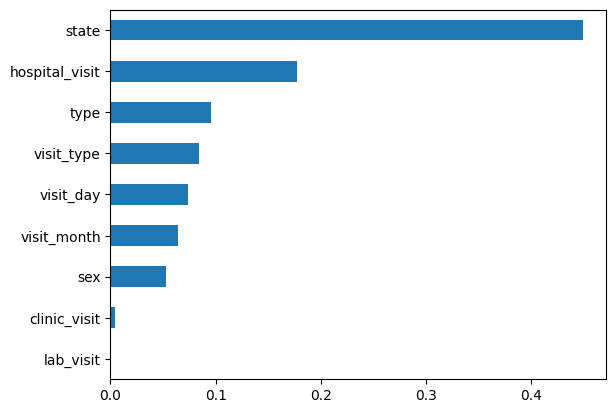

In [37]:
pd.Series(model_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)[::-1].plot.barh()

In [38]:
## Explainer

In [41]:
# from explainerdashboard import RegressionExplainer

# explainer = RegressionExplainer(model_xgb, X_test, y_test)

In [42]:
# from explainerdashboard import ExplainerDashboard
# ExplainerDashboard(explainer, shap_interaction=False).run()